<a href="https://colab.research.google.com/github/hansq7777/Myelin_Seg/blob/main/2025Feb_myelin_seg_2_5D_nnUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
print("version:", sys.version)

version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [ ]:
!nvidia-smi  # 查看 GPU 状态，Colab 需要选择 GPU 运行环境

!pip install nnunetv2
!pip install SimpleITK
!pip install --upgrade triton
!pip install PyWavelets

Sun Feb  2 21:08:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.2/253.2 MB 4.5 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires triton==3.1.0; platform_system == "Linux" and platform_machine == "x86_64" and python_version < "3.13", but you have triton 3.2.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 51.8 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade pip setuptools wheel
!pip install --force-reinstall --no-cache-dir numpy scikit-image lazy_loader pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.7 MB/s eta 0:00:00
  Using cached setuptools-75.8.0-py3-none-any.whl (1.2 MB)
  Using cached wheel-0.45.1-py3-none-any.whl (72 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.1
    Uninstalling wheel-0.37.1:
      Successfully uninstalled wheel-0.37.1
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.5.0
    Uninstalling setuptools-65.5.0:
      Successfully uninstalled setuptools-65.5.0
  Attempting uninstall: pip
    Found existing installation: pip 22.3
    Uninstalling pip-22.3:
      Successfully uninstalled pip-22.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 188.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 222.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 364.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 305.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 73.9 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 11.1.0
    Uninstalling pillow-11.1.0:
      Successfully uninstalled pillow-11.1.0
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.2
    Uninstalling numpy-2.2.2:
      Successfully uninstalled numpy-2.2.2
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstal

In [ ]:
##### 1.准备nnunet所需的文件结构 #####
import os
# 设置目标根目录
base_dir = '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw/Dataset001_Myelin'

# 依次创建所需子目录
os.makedirs(os.path.join(base_dir, 'imagesTr'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'labelsTr'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'imagesTs'), exist_ok=True)

print("目录结构已创建完毕。")

目录结构已创建完毕。


In [ ]:
##### 2. 预处理图片组成三通道2.5D，同时进行25%上下限clip和均一化 #####
import os
import numpy as np
import nibabel as nib
from skimage import io
from tqdm import tqdm
import shutil  # 用于删除子文件夹

# ========== 新增：用于记录不同输入/输出维度出现的次数 ==========
dimension_counter_in = {}
dimension_counter_out = {}

def ensure_3d_shape_z_hw(img_data):
    """
    假设输入是一个最多三维数组 (d1, d2, d3)，
    找出最小维作为 Z，并转置成 (Z, H, W)。
    如果是 2D，则假设它是 (H, W)，会自动扩成 (1, H, W)。
    """
    shape_in = img_data.shape
    ndim_in = len(shape_in)

    if ndim_in == 2:
        # 2D => (1, H, W)
        return np.expand_dims(img_data, axis=0)

    if ndim_in == 3:
        d1, d2, d3 = shape_in
        dims = [d1, d2, d3]
        min_idx = int(np.argmin(dims))
        if min_idx == 0:
            return img_data  # (Z, H, W) 假设没问题
        elif min_idx == 1:
            return np.transpose(img_data, (1, 0, 2))  # (Z, H, W)
        else:
            return np.transpose(img_data, (2, 0, 1))  # (Z, H, W)

    raise ValueError(f"图像维度不在预期范围内，shape={shape_in}")


def do_25_75_clipping_2D(slice_data):
    """
    对 2D slice_data 计算 25% 和 75% 分位数，
    将像素裁剪到 [lower, upper] 后，拉伸到 [0, 255]。
    返回 float32 数组。
    """
    slice_data = slice_data.astype(np.float32, copy=False)
    lower = np.percentile(slice_data, 25)
    upper = np.percentile(slice_data, 75)

    # clip
    slice_data = np.clip(slice_data, lower, upper)
    # 线性拉伸到 [0, 255]
    denom = max(upper - lower, 1e-8)
    slice_data = (slice_data - lower) / denom * 255.0

    return slice_data.astype(np.float32)


# ========== 用户根据需要自行修改以下路径 ==========
input_folders = [
    '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/1.raw z stacks/training',
    '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/2.preprocessed z stacks'
]
output_folder = '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw/Dataset001_Myelin/imagesTr'

os.makedirs(output_folder, exist_ok=True)

# ========== 新增：清空目标文件夹，删除该目录下所有内容 ==========
for filename in os.listdir(output_folder):
    file_path = os.path.join(output_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f"删除 {file_path} 时出现错误：{e}")

# ========== 处理每个输入文件夹 ==========
for input_folder in input_folders:
    print(f"Processing folder: {input_folder}")

    file_list = [
        f for f in os.listdir(input_folder)
        if (f.lower().endswith('.tif') or f.lower().endswith('.nii.gz'))
    ]

    for file_name in tqdm(file_list, desc=f"Processing files in {input_folder}"):
        input_path = os.path.join(input_folder, file_name)

        # ========== 1. 读取文件，区分 nii.gz 或 tif ==========
        if file_name.lower().endswith('.nii.gz'):
            nii_img = nib.load(input_path)
            img_data = nii_img.get_fdata()  # float64
            affine = nii_img.affine
            header = nii_img.header
        else:
            img_data = io.imread(input_path)
            affine = np.eye(4)
            header = nib.Nifti1Header()

        # 原始维度统计
        in_shape = img_data.shape
        dimension_counter_in[in_shape] = dimension_counter_in.get(in_shape, 0) + 1

        # ========== 让最小维做 Z，得到 (Z, H, W) 形状 ==========
        img_data = ensure_3d_shape_z_hw(img_data)
        Z, H, W = img_data.shape

        basename = file_name.replace('.nii.gz', '').replace('.tif', '')
        total_slices_saved = 0

        # ========== 2. 遍历 Z，每个 z 构建3通道，并做 25/75 clipping ==========
        for z_idx in range(Z):
            z_previous = z_idx - 1 if z_idx - 1 >= 0 else z_idx
            z_next = z_idx + 1 if z_idx + 1 < Z else z_idx

            slices_list = [
                img_data[z_previous, :, :],
                img_data[z_idx, :, :],
                img_data[z_next, :, :],
            ]

            # 依次保存三通道，每通道都做 clipping
            for ch_idx, single_channel_data in enumerate(slices_list):
                # ========== 新增：对该 channel 2D 数据做 25/75 clipping + 拉伸 ==========
                single_channel_data = do_25_75_clipping_2D(single_channel_data)

                # 转成 (1, H, W)
                single_channel_data = np.expand_dims(single_channel_data, axis=0)

                out_shape = single_channel_data.shape
                dimension_counter_out[out_shape] = dimension_counter_out.get(out_shape, 0) + 1

                out_filename = f"{basename}_{str(z_idx).zfill(4)}_{str(ch_idx).zfill(4)}.nii.gz"
                out_path = os.path.join(output_folder, out_filename)

                out_nii = nib.Nifti1Image(single_channel_data, affine, header)
                nib.save(out_nii, out_path)
                total_slices_saved += 1

        print(f"\n{file_name} 处理完毕：最初 shape={in_shape} -> (Z,H,W)=({Z},{H},{W})，"
              f"3 通道，共 {total_slices_saved} 张切片（含 clipping）已保存。")

print("全部文件处理完成。")

# ========== 维度统计汇总 ==========
print("\n===== 维度统计汇总 =====")
print("【输入时实际读取到的 shape】")
for shp_in, count_in in dimension_counter_in.items():
    print(f"  shape={shp_in}: {count_in} 个文件")

print("\n【输出为单通道 nii.gz 时的 shape】")
for shp_out, count_out in dimension_counter_out.items():
    print(f"  shape={shp_out}: {count_out} 个文件")

Processing folder: /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/1.raw z stacks/training


Processing files in /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/1.raw z stacks/training:  33%|███▎      | 1/3 [00:05<00:11,  5.92s/it]


pig hippocampus interface.tif 处理完毕：最初 shape=(59, 512, 512) -> (Z,H,W)=(59,512,512)，3 通道，共 177 张切片（含 clipping）已保存。


Processing files in /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/1.raw z stacks/training:  67%|██████▋   | 2/3 [00:11<00:05,  5.56s/it]


rat 144L S1BF im25.tif 处理完毕：最初 shape=(53, 512, 512) -> (Z,H,W)=(53,512,512)，3 通道，共 159 张切片（含 clipping）已保存。


Processing files in /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/1.raw z stacks/training: 100%|██████████| 3/3 [00:16<00:00,  5.36s/it]



rat 144L S1BF im27.tif 处理完毕：最初 shape=(53, 512, 512) -> (Z,H,W)=(53,512,512)，3 通道，共 159 张切片（含 clipping）已保存。
Processing folder: /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/2.preprocessed z stacks


Processing files in /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/2.preprocessed z stacks: 0it [00:00, ?it/s]

全部文件处理完成。

===== 维度统计汇总 =====
【输入时实际读取到的 shape】
  shape=(59, 512, 512): 1 个文件
  shape=(53, 512, 512): 2 个文件

【输出为单通道 nii.gz 时的 shape】
  shape=(1, 512, 512): 495 个文件


正在清空文件夹: /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw/Dataset001_Myelin/labelsTr
=== labelsTr 文件夹已清空/创建完毕 ===

=== 开始切割并保存标注文件到 labelsTr 文件夹 ===


Converting TIF -> NIfTI slices: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


=== 标注文件切割并保存完毕 ===

随机选取标注文件: rat 144L S1BF im27.tif, shape=(53, 512, 512)


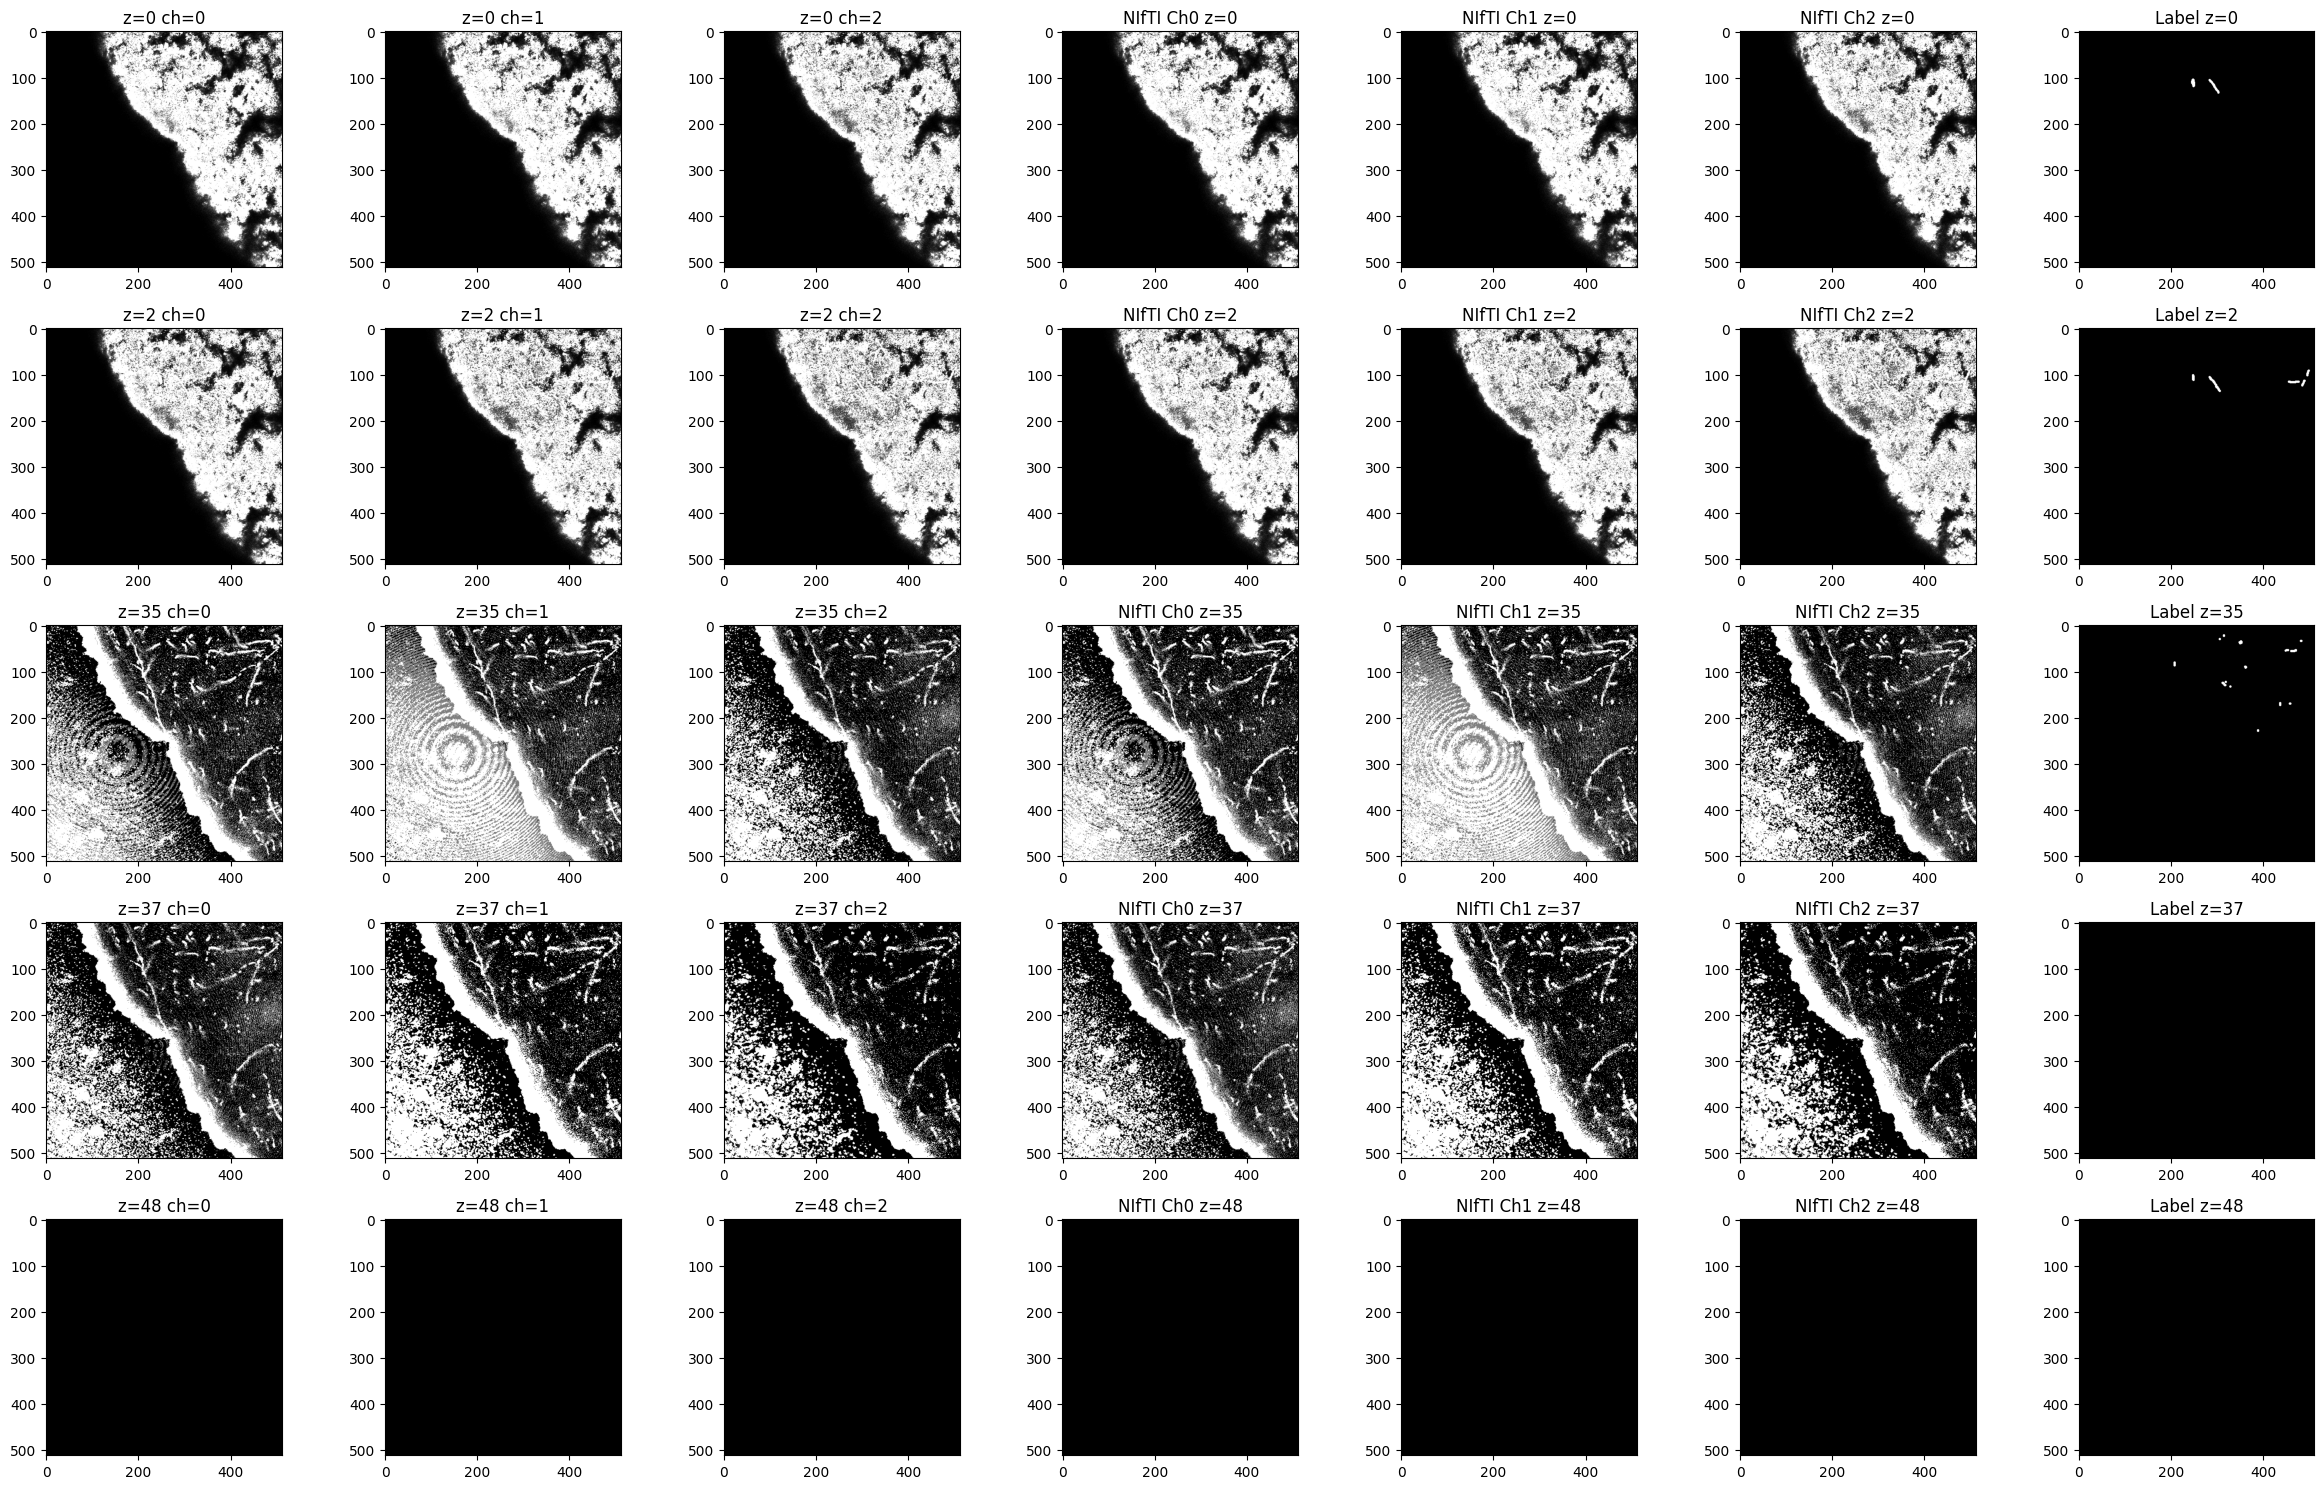

可视化完成！


In [ ]:
##### 3. 分割tif标注文件并转化转移为nii.gz，找到对应原始图片的三通道一并可视化 #####

import os
import shutil
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm

# ========== 0. 清空 labelsTr 文件夹，保证最新分割输出 ==========

labelsTr_folder = '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw/Dataset001_Myelin/labelsTr'
# labelsTr_folder = '/content/nnUNet_Data/nnUNet_raw/Dataset001_Myelin/labelsTr'
if os.path.isdir(labelsTr_folder):
    print(f"正在清空文件夹: {labelsTr_folder}")
    for filename in os.listdir(labelsTr_folder):
        file_path = os.path.join(labelsTr_folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"删除 {file_path} 失败: {e}")
else:
    os.makedirs(labelsTr_folder, exist_ok=True)
    print(f"已创建空文件夹: {labelsTr_folder}")

print(f"=== labelsTr 文件夹已清空/创建完毕 ===\n")


# ========== 确保维度顺序是 (Z, H, W) 的函数（与第3段代码相同） ==========
def ensure_3d_shape_z_hw(img_data):
    """
    假设输入是一个最多三维数组 (d1, d2, d3)，
    找出最小维作为 Z，并转置成 (Z, H, W)。
    如果是 2D，则假设它是 (H, W)，自动扩成 (1, H, W)。
    """
    shape_in = img_data.shape
    ndim_in = len(shape_in)

    # 若是 2D (H, W)，自动扩成 (1, H, W)
    if ndim_in == 2:
        return np.expand_dims(img_data, axis=0)  # => (1, H, W)

    if ndim_in == 3:
        d1, d2, d3 = shape_in
        dims = [d1, d2, d3]
        min_idx = int(np.argmin(dims))
        # 若 min_idx = 0 => 已经是 (Z, H, W)
        # 若 min_idx = 1 => (H, Z, W)，转成 (Z, H, W)
        # 若 min_idx = 2 => (H, W, Z)，转成 (Z, H, W)
        if min_idx == 0:
            return img_data
        elif min_idx == 1:
            return np.transpose(img_data, (1, 0, 2))
        else:  # min_idx == 2
            return np.transpose(img_data, (2, 0, 1))

    raise ValueError(f"图像维度不在预期范围内，原始 shape={shape_in}")


# ========== 路径设定 ==========

ann_folder = '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/3.annotation'
imagesTr_folder = '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw/Dataset001_Myelin/imagesTr'
# imagesTr_folder = '/content/nnUNet_Data/nnUNet_raw/Dataset001_Myelin/imagesTr'


os.makedirs(labelsTr_folder, exist_ok=True)

# ========== 1. 读取 annotation 文件夹下的所有 TIF 文件，并切割为 2D 保存到 labelsTr ==========

tif_files = [f for f in os.listdir(ann_folder) if f.lower().endswith('.tif')]

print("=== 开始切割并保存标注文件到 labelsTr 文件夹 ===")
for tif_name in tqdm(tif_files, desc="Converting TIF -> NIfTI slices"):
    tif_path = os.path.join(ann_folder, tif_name)

    # 读取 TIF（可能形状并不一定是 (Z,H,W)，因此用 ensure_3d_shape_z_hw 做安全处理）
    label_stack = io.imread(tif_path)
    label_stack = ensure_3d_shape_z_hw(label_stack)  # 确保输出 (Z, H, W)

    Z, H, W = label_stack.shape

    # basename 去掉 .tif 后缀
    basename = tif_name.replace('.tif', '')

    # 逐 Z 切片，并保存为 basename_xxxx.nii.gz
    for z_idx in range(Z):
        slice_2d = label_stack[z_idx, :, :]

        # 扩展成 (1,H,W)，以符合 nnUNet 的 (C,H,W) 格式
        slice_2d = np.expand_dims(slice_2d, axis=0)

        out_filename = f"{basename}_{str(z_idx).zfill(4)}.nii.gz"
        out_path = os.path.join(labelsTr_folder, out_filename)

        # 这里给一个默认的 affine 和 header
        affine = np.eye(4)
        header = nib.Nifti1Header()

        out_nii = nib.Nifti1Image(slice_2d.astype(np.uint16), affine, header)
        nib.save(out_nii, out_path)

print("=== 标注文件切割并保存完毕 ===")

# ========== 2. 随机选取一个标注文件（原 TIF），并随机选取其中 5 张 Z 切片可视化 ==========

if len(tif_files) == 0:
    print("警告：3.annotation 文件夹中无 TIF 文件，无法进行后续可视化示例。")
else:
    chosen_tif = random.choice(tif_files)  # 随机选一个
    chosen_tif_path = os.path.join(ann_folder, chosen_tif)
    chosen_label_stack = io.imread(chosen_tif_path)
    chosen_label_stack = ensure_3d_shape_z_hw(chosen_label_stack)  # 再次确保 (Z,H,W)

    Z, H, W = chosen_label_stack.shape
    chosen_basename = chosen_tif.replace('.tif', '')

    print(f"\n随机选取标注文件: {chosen_tif}, shape={chosen_label_stack.shape}")

    # 如果 Z < 5, 则展示所有 Z 切片；否则随机选 5 个
    if Z <= 5:
        slice_indices = list(range(Z))
    else:
        slice_indices = random.sample(range(Z), 5)
    slice_indices.sort()  # 排序便于阅读

    # 可视化: 每个 slice 显示 7 幅图
    # 前3列为三通道原图(每通道一幅)，第4~6列再次展示通道0/1/2
    # 第7列为标注切片
    fig, axes = plt.subplots(len(slice_indices), 7, figsize=(24, 3 * len(slice_indices)))
    if len(slice_indices) == 1:
        axes = np.expand_dims(axes, axis=0)  # 保证 row 索引

    for row_idx, z_idx in enumerate(slice_indices):
        z_str = str(z_idx).zfill(4)

        # 在 imagesTr 中找到对应三通道 NIfTI 文件
        channel_images = []
        for ch_idx in range(3):
            ch_str = str(ch_idx).zfill(4)
            nii_fname = f"{chosen_basename}_{z_str}_{ch_str}.nii.gz"
            nii_fpath = os.path.join(imagesTr_folder, nii_fname)

            if os.path.exists(nii_fpath):
                nii_img = nib.load(nii_fpath)
                img_data = nii_img.get_fdata()

                # 这里也再保证一下是 (Z,H,W)，但因为本来就是单切片单通道：
                # 最终应变成 (1,H,W)；只取第 0 张切片即可视为 (H,W)
                img_data = ensure_3d_shape_z_hw(img_data)  # => (1, H, W) 或 (Z, H, W)
                if img_data.shape[0] == 1:
                    img_data = img_data[0, :, :]  # => (H, W)
                channel_images.append(img_data)
            else:
                print(f"警告：未找到文件 {nii_fpath}，将使用空白图像填充。")
                channel_images.append(np.zeros((H, W)))

        # 显示三通道图像 (ch0, ch1, ch2)
        for ch_idx, img in enumerate(channel_images):
            axes[row_idx, ch_idx].imshow(img, cmap='gray')
            axes[row_idx, ch_idx].set_title(f"z={z_idx} ch={ch_idx}")

        # 显示标注
        label_slice = chosen_label_stack[z_idx, :, :]
        # 这里演示简单二值化可视
        label_binarized = np.where(label_slice > 0, 255, 0).astype(np.uint8)

        axes[row_idx, 3].imshow(channel_images[0], cmap='gray')
        axes[row_idx, 3].set_title(f"NIfTI Ch0 z={z_idx}")

        axes[row_idx, 4].imshow(channel_images[1], cmap='gray')
        axes[row_idx, 4].set_title(f"NIfTI Ch1 z={z_idx}")

        axes[row_idx, 5].imshow(channel_images[2], cmap='gray')
        axes[row_idx, 5].set_title(f"NIfTI Ch2 z={z_idx}")

        axes[row_idx, 6].imshow(label_binarized, cmap='gray')
        axes[row_idx, 6].set_title(f"Label z={z_idx}")

    plt.tight_layout()
    plt.show()
    print("可视化完成！")

In [ ]:
##### 4. 根据数据结构、任务类型、文件分布设置json配置文件 #####

import os
import json

# =========================================
# 数据集路径（raw 数据集所在）
# =========================================
dataset_dir = '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw/Dataset001_Myelin'
# dataset_dir = '/content/nnUNet_Data/nnUNet_raw/Dataset001_Myelin'
labelsTr_folder = os.path.join(dataset_dir, 'labelsTr')
json_path = os.path.join(dataset_dir, 'dataset.json')

# =========================================
# 1. 读取 labelsTr 文件夹，统计 .nii.gz 文件的数量，作为训练集数量
# =========================================
all_label_files = [
    f for f in os.listdir(labelsTr_folder)
    if f.lower().endswith('.nii.gz')
]
num_training = len(all_label_files)
print(f"在 {labelsTr_folder} 中共检测到 {num_training} 个标注切片 (.nii.gz)。")

# =========================================
# 2. 构建新的 JSON 数据
# =========================================
dataset_info = {
    "name": "MyelinSeg2.5D",
    "description": "Myelin segmentation with 2.5D input (3 channels: prev/current/next slices)",
    "reference": "",
    "licence": "",
    "release": "1.0",

    # 对于多通道，nnUNet v2 依赖 channel_names 的键为字符串 "0", "1", "2", ...
    "channel_names": {
        "0": "prev_slice",
        "1": "current_slice",
        "2": "next_slice"
    },
    # "channel_names": {
    #     "0": "noNorm",
    #     "1": "noNorm",
    #     "2": "noNorm"
    # },
    # label 映射：int to class name
    "labels": {
        "background": 0,
        "myelin": 1
    },

    # 重要：将刚刚统计得到的数写入
    "numTraining": num_training,
    # 若无测试集，可不写 numTest；或者写成 "numTest": 0
    "numTest": 0,
    "file_ending": ".nii.gz",

    # 对于 2D/2.5D，大多写 "tensorImageSize": "2D"（其实不写也问题不大）
    "tensorImageSize": "2D"
}

# =========================================
# 3. 创建 / 覆盖 dataset.json 文件
# =========================================
if os.path.exists(json_path):
    print(f"文件 '{json_path}' 已存在，将被覆盖...")
else:
    print(f"文件 '{json_path}' 不存在，将创建新文件...")

with open(json_path, 'w') as f:
    json.dump(dataset_info, f, indent=4)

print(f"新 dataset.json 已保存到: {json_path}")

在 /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw/Dataset001_Myelin/labelsTr 中共检测到 165 个标注切片 (.nii.gz)。
文件 '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw/Dataset001_Myelin/dataset.json' 已存在，将被覆盖...
新 dataset.json 已保存到: /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw/Dataset001_Myelin/dataset.json


In [ ]:
##### 5. 设置原始数据文件夹、预处理数据文件夹、和训练模型保存文件夹环境变量 #####
import os

# Define the required directories
required_dirs = [
    "/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw",
    "/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_preprocessed",
    "/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_results",
]

# Check if each directory exists, and create it if it doesn't
for dir_path in required_dirs:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)
        print(f"Created directory: {dir_path}")
    else:
        print(f"Directory already exists: {dir_path}")

# Define and ensure the required directories exist
os.environ["nnUNet_raw"] = "/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw"
os.environ["nnUNet_preprocessed"] = "/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_preprocessed"
os.environ["nnUNet_results"] = "/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_results"

# Create the directories if they do not exist
for key in ["nnUNet_raw", "nnUNet_preprocessed", "nnUNet_results"]:
    path = os.environ[key]
    os.makedirs(path, exist_ok=True)

# Verify the directory paths
os.environ["nnUNet_raw"], os.environ["nnUNet_preprocessed"], os.environ["nnUNet_results"]

Directory already exists: /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw
Directory already exists: /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_preprocessed
Directory already exists: /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_results


('/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_raw',
 '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_preprocessed',
 '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/nnUNet_Data/nnUNet_results')

In [ ]:
##### 6. 运行预处理 #####
import subprocess

# Run the command and capture the output
result = subprocess.run(
    ["nnUNetv2_plan_and_preprocess", "-d", "1", "--verify_dataset_integrity"],
    capture_output=True,
    text=True
)

# Print the standard output and error
print("Standard Output:")
print(result.stdout)

print("\nStandard Error:")
print(result.stderr)

Standard Output:
Fingerprint extraction...
Dataset001_Myelin
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 8, 'patch_size': (512, 512), 'median_image_size_in_voxels': array([512., 512.]), 'spacing': array([1., 1.]), 'normalization_schemes': ['ZScoreNormalization', 'ZScoreNormalization', 'ZScoreNormalization'], 'use_mask_for_norm': [False, False, False], 'resampling_fn_data': 'resamp

In [ ]:
import os

trainer_code = r'''
import torch
from nnunetv2.training.nnUNetTrainer.nnUNetTrainer import nnUNetTrainer

class nnUNetTrainer_100epochs_lr001(nnUNetTrainer):
    def __init__(self,
                 plans: dict,
                 configuration: str,
                 fold: int,
                 dataset_json: dict,
                 unpack_dataset: bool = True,
                 device: torch.device = torch.device('cuda')):
        """
        在 nnUNetTrainer 的基础上自定义:
        1) 训练 100 个 epoch
        2) 初始学习率 (initial_lr) = 0.001
        """
        super().__init__(plans, configuration, fold, dataset_json, unpack_dataset, device)
        self.num_epochs = 100
        self.initial_lr = 0.001

    def setup_optimizer_and_scheduler(self):
        # 先用父类逻辑创建optimizer、scheduler
        super().setup_optimizer_and_scheduler()
        # 然后覆盖学习率
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.initial_lr
'''

# 预定义两个可能的路径
path_3_11 = "/usr/local/lib/python3.11/dist-packages/nnunetv2/training/nnUNetTrainer/nnUNetTrainer_100epochs_lr001.py"
path_3_10 = "/usr/local/lib/python3.10/dist-packages/nnunetv2/training/nnUNetTrainer/nnUNetTrainer_100epochs_lr001.py"

# 判断哪个目录存在就写到哪个目录下
if os.path.exists("/usr/local/lib/python3.11/dist-packages"):
    target_path = path_3_11
elif os.path.exists("/usr/local/lib/python3.10/dist-packages"):
    target_path = path_3_10
else:
    raise EnvironmentError("未找到合适的 Python 版本路径，请检查 Python 3.10 或 3.11 是否安装。")

# 确保目标文件夹存在（如果不存在就创建）
os.makedirs(os.path.dirname(target_path), exist_ok=True)

# 将自定义的 Trainer 代码写入目标文件
with open(target_path, 'w', encoding='utf-8') as f:
    f.write(trainer_code)

print(f"已创建自定义Trainer文件:\n  {target_path}")


已创建自定义Trainer文件:
  /usr/local/lib/python3.11/dist-packages/nnunetv2/training/nnUNetTrainer/nnUNetTrainer_100epochs_lr001.py


In [ ]:
!cat /usr/local/lib/python3.11/dist-packages/nnunetv2/training/nnUNetTrainer/nnUNetTrainer_100epochs_lr001.py



import torch
from nnunetv2.training.nnUNetTrainer.nnUNetTrainer import nnUNetTrainer

class nnUNetTrainer_100epochs_lr001(nnUNetTrainer):
    def __init__(self,
                 plans: dict,
                 configuration: str,
                 fold: int,
                 dataset_json: dict,
                 unpack_dataset: bool = True,
                 device: torch.device = torch.device('cuda')):
        """
        在 nnUNetTrainer 的基础上自定义:
        1) 训练 100 个 epoch
        2) 初始学习率 (initial_lr) = 0.001
        """
        super().__init__(plans, configuration, fold, dataset_json, unpack_dataset, device)
        self.num_epochs = 100
        self.initial_lr = 0.001

    def setup_optimizer_and_scheduler(self):
        # 先用父类逻辑创建optimizer、scheduler
        super().setup_optimizer_and_scheduler()
        # 然后覆盖学习率
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.initial_lr


In [ ]:
!pip install --upgrade torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 84.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu124
    Uninstalling torch-2.5.1+cu124:
      Successfully uninstalled torch-2.5.1+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu124
    Uninstalling torchvision-0.20.1+cu124:
      Successfully uninstalled torchvision-0.20.1+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.5.1+cu124
    Uninstalling torchaudio-2.5.1+cu124:
      Successfully uninstalled torchaudio-2.5.1+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

In [ ]:
##### 8.进行模型训练（在results文件夹里看最新进展） #####
import subprocess

cmd = [
    "nnUNetv2_train",
    "1",
    "2d",
    "0", #all for 5 fold
    "--npz",
    "-tr=nnUNetTrainer_100epochs_lr001"
]

result = subprocess.run(cmd, capture_output=True, text=True)

# 打印标准输出和标准错误，便于调试
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

# 如果需要判断命令是否成功执行，可以检查 returncode
if result.returncode != 0:
    print(f"训练脚本执行失败，返回码: {result.returncode}")
else:
    print("训练脚本执行成功！")

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import nibabel as nib
from skimage import io
from tqdm import tqdm
import shutil

# ========== 路径设定 ==========
input_folder = '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/1.raw z stacks/inference'
output_folder = '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/4.preprocessed for inference'  # 修改为本地路径

# ========== 0. 清空输出文件夹(如果存在) ==========
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)  # 直接删除该文件夹及其下所有内容
os.makedirs(output_folder, exist_ok=True)

# ========== 1. 遍历 inference 文件夹下的所有 .tif 文件 ==========
file_list = [f for f in os.listdir(input_folder) if f.lower().endswith('.tif')]

for file_name in tqdm(file_list, desc="Preparing inference data"):
    input_path = os.path.join(input_folder, file_name)

    # ========== 2. 读取 .tif (假设 shape = (Z, H, W)) ==========
    img_data = io.imread(input_path)
    # 如果你的 tif 并非 (Z,H,W)，需在此根据实际情况做 reshape 或 transpose

    # 这里给一个默认的 affine 和 header
    affine = np.eye(4)
    header = nib.Nifti1Header()

    # 提取 Z, H, W
    Z, H, W = img_data.shape
    basename = file_name.replace('.tif', '')

    total_slices_saved = 0

    # ========== 3. 每个 z 构造 3 通道 (prev, current, next) ==========
    for z_idx in range(Z):
        z_previous = z_idx - 1 if z_idx - 1 >= 0 else z_idx
        z_next = z_idx + 1 if z_idx + 1 < Z else z_idx

        # 三通道切片
        slices_list = [
            img_data[z_previous, :, :],
            img_data[z_idx, :, :],
            img_data[z_next, :, :],
        ]

        # ========== 4. 对每个单通道做 25% ~ 75% 分位点 clipping，然后映射到 [0, 255]，再保存 .nii.gz ==========
        for ch_idx, single_channel_data in enumerate(slices_list):
            # 1) 计算 25% 和 75% 分位点
            p25 = np.percentile(single_channel_data, 25)
            p75 = np.percentile(single_channel_data, 75)

            # 2) clipping
            single_channel_data = np.clip(single_channel_data, p25, p75)

            # 3) 若 p75 != p25，则做归一化映射到 [0,255]
            if p75 > p25:
                single_channel_data = (single_channel_data - p25) / (p75 - p25)
                single_channel_data = single_channel_data * 255.0
            else:
                # 避免除以 0；如果整片都相同值，则直接置 0
                single_channel_data = np.zeros_like(single_channel_data)

            # 4) 若需要 8 位存储，转成 uint8；若后续需要更高精度可用 float32
            single_channel_data = single_channel_data.astype(np.uint8)

            # 5) 添加通道维度 (1, H, W)，准备保存
            single_channel_data = np.expand_dims(single_channel_data, axis=0)

            out_filename = f"{basename}_{str(z_idx).zfill(4)}_{str(ch_idx).zfill(4)}.nii.gz"
            out_path = os.path.join(output_folder, out_filename)

            # 6) 保存为 NIfTI 格式
            out_nii = nib.Nifti1Image(single_channel_data, affine, header)
            nib.save(out_nii, out_path)

            total_slices_saved += 1

    # ========== 5. 打印该文件的处理总结 ==========
    print(f"{file_name} 完成：Z={Z}, 3 通道 => 共生成 {total_slices_saved} 个 .nii.gz 文件。")

print("全部推理数据的 2.5D 预处理已完成！")


Preparing inference data:  25%|██▌       | 1/4 [00:05<00:15,  5.14s/it]

0  slice 144 left hemisphere S1BF_[ii19_slice_144_left_hemisphere_S1BF_Image_20].ims Resolution Level 1.tif 完成：Z=53, 3 通道 => 共生成 159 个 .nii.gz 文件。


Preparing inference data:  50%|█████     | 2/4 [00:11<00:11,  5.81s/it]

0  slice 144 left hemisphere S1BF_[ii20_slice_144_left_hemisphere_S1BF_Image_21].ims Resolution Level 1.tif 完成：Z=53, 3 通道 => 共生成 159 个 .nii.gz 文件。


Preparing inference data:  75%|███████▌  | 3/4 [00:15<00:05,  5.01s/it]

0  slice 144 left hemisphere S1BF_[ii23_slice_144_left_hemisphere_S1BF_Image_24].ims Resolution Level 1.tif 完成：Z=53, 3 通道 => 共生成 159 个 .nii.gz 文件。


Preparing inference data: 100%|██████████| 4/4 [00:20<00:00,  5.01s/it]

0  slice 144 left hemisphere S1BF_[ii25_slice_144_left_hemisphere_S1BF_Image_26].ims Resolution Level 1.tif 完成：Z=53, 3 通道 => 共生成 159 个 .nii.gz 文件。
全部推理数据的 2.5D 预处理已完成！


In [ ]:
file_path = "/usr/local/lib/python3.11/dist-packages/nnunetv2/inference/predict_from_raw_data.py"

with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

i = 0
while i < len(lines) - 1:
    line_current = lines[i]
    line_next = lines[i+1]

    # 判断第 i 行是否包含 checkpoint = torch.load(
    # 且第 i+1 行包含 map_location=torch.device('cpu')
    if ("checkpoint = torch.load(" in line_current
        and "map_location=torch.device('cpu')" in line_next
        and "weights_only=False" not in line_current
        and "weights_only=False" not in line_next):

        # 把两行合并成一行
        # 例如:
        #   line i:   checkpoint = torch.load(join(...),
        #   line i+1:     map_location=torch.device('cpu'))
        # 我们合并后插入 weights_only=False:
        #   checkpoint = torch.load(join(...), map_location=torch.device('cpu'), weights_only=False)

        line_current = line_current.rstrip('\n')   # 去掉行尾换行
        line_next = line_next.strip()             # 去掉行首空格
        merged_line = line_current + " " + line_next  # 合并

        # 在 merged_line 中把 "map_location=torch.device('cpu'))"
        # 替换为 "map_location=torch.device('cpu'), weights_only=False)"
        merged_line = merged_line.replace(
            "map_location=torch.device('cpu'))",
            "map_location=torch.device('cpu'), weights_only=False)"
        )

        # 将替换结果写回到 lines[i]，然后把 lines[i+1] 设置为空行
        lines[i] = merged_line + "\n"
        lines[i+1] = ""  # 清空下一行
        # 替换完后，就可以继续往下处理
        i += 2
    else:
        i += 1

# 将修改后的内容写回
with open(file_path, "w", encoding="utf-8") as f:
    f.writelines(lines)

print("修改完成！请检查是否已插入 weights_only=False。")


修改完成！请检查是否已插入 weights_only=False。


In [ ]:
!grep "weights_only" /usr/local/lib/python3.11/dist-packages/nnunetv2/inference/predict_from_raw_data.py


            checkpoint = torch.load(join(model_training_output_dir, f'fold_{f}', checkpoint_name), map_location=torch.device('cpu'), weights_only=False)


In [ ]:
##### 11.使用1号数据库中的checkpoint_final.pth当前模型进行预测 #####
import subprocess

result = subprocess.run(
    [
        "nnUNetv2_predict",
        "-i", "/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/4.preprocessed for inference",
        "-o", "/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/5.inference output",
        "-d", "1",                                 # dataset_id
        "-c", "2d",                                # 使用2D配置
        "-f", "0",                                 # fold=0
        "-tr=nnUNetTrainer_100epochs_lr001",  # 指定自定义Trainer
        "--save_probabilities"                     # 保存概率图
    ],
    capture_output=True,
    text=True
)

print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)

# "-d"指定1，使用1号数据库对应的训练模型进行预测；"-c"是configuration，要指定2d；"-f"是fold，必须设定0fold否则代码会开始搜寻fold1-4并停止

In [ ]:
##### 12.模型inference完成后，将nii.gz文件的output组合成tif #####

import os
import re
import nibabel as nib
import numpy as np
from skimage import io

# 输入与输出文件夹
input_folder = '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/5.inference output'
output_folder = '/content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/6.segmentation results'
os.makedirs(output_folder, exist_ok=True)

# 用来存储 { basename: {z_idx: 图像数据(2D) } }
images_dict = {}

# ========== 1. 扫描 5.inference output 中所有 .nii.gz 文件 ==========
for fname in os.listdir(input_folder):
    if fname.lower().endswith('.nii.gz'):
        fpath = os.path.join(input_folder, fname)

        # ========== 2. 解析 basename 和 z_index ==========
        # 假设命名类似: "basename_0000.nii.gz" 或 "basename_0000_0000.nii.gz"
        # 可以用正则或 split 来获取最后一个数字(或指定位置)

        # 方法1: split('_') 拿倒数第二个做 z_index (适合 "basename_0000_0000.nii.gz" 情况)
        # 方法2: 如果你的命名规律总是 "basename_XXXX.nii.gz", 就取 split('_')[-1][:4]
        #       这里给个通用正则示例，从右往左匹配一段数字

        match = re.search(r'_([0-9]{4})(?:_|)\.nii\.gz$', fname)
        # 如果找不到说明命名不符合预期
        if not match:
            print(f"[警告] 文件 {fname} 命名格式无法解析出 z_index，跳过。")
            continue

        z_str = match.group(1)  # "0000" 之类
        z_idx = int(z_str)

        # 解析 basename：去掉 "_xxxx.nii.gz" 或 "_xxxx_yyyy.nii.gz" 部分
        # 方式：先把后缀去掉，再把最后一个 "_xxxx" 删掉
        # fname_no_ext = fname.replace('.nii.gz', '')  # 例如 "basename_0000_0000"
        # 然后根据 match.start() 找到下划线位置也行，这里给一个简化 split:
        fname_no_ext = fname[:-7]  # 去掉 .nii.gz => "basename_0000_0000"
        # 拿到本次出现的匹配(末尾4位数字的起始)，进行切片
        idx_start = match.start(1)  # 数字组在整个fname中的起始位置
        basename = fname_no_ext[:idx_start-1]  # -1是去掉下划线

        # ========== 3. 读取 2D 切片数据 ==========
        nii_img = nib.load(fpath)
        data_3d = nii_img.get_fdata()  # 可能是 (1,H,W) 或 (H,W)

        # 把 (1,H,W) squeeze 成 (H,W)
        if data_3d.ndim == 3 and data_3d.shape[0] == 1:
            data_2d = data_3d[0, ...]
        else:
            data_2d = data_3d  # 假设本身就是 (H,W)

        data_2d = data_2d.astype(np.float32)  # 可根据需要转成别的类型，比如 uint8

        # 存到字典
        if basename not in images_dict:
            images_dict[basename] = {}
        images_dict[basename][z_idx] = data_2d


# ========== 4. 对每个 basename，按 z_idx 升序堆叠并保存为 tif ==========
for basename, slice_dict in images_dict.items():
    # 收集所有 z_idx 并排序
    z_indices = sorted(slice_dict.keys())
    Z = len(z_indices)

    # 取出任意一片，查看 (H, W)
    first_z = z_indices[0]
    H, W = slice_dict[first_z].shape

    # 创建一个空的 (Z,H,W) 用于堆叠
    stack_3d = np.zeros((Z, H, W), dtype=np.float32)

    # 依次把 slice 放到 stack_3d
    for i, z_idx in enumerate(z_indices):
        stack_3d[i, :, :] = slice_dict[z_idx]

    # ========== 5. 保存为 3D tif ==========
    out_tif_name = f"{basename}.tif"
    out_tif_path = os.path.join(output_folder, out_tif_name)

    # 如果 stack 很大，可以考虑设置 'bigtiff=True' 等参数
    # 注意 skimage.io.imsave 默认写入多帧时只支持 tiff, gif, etc.
    # 这里直接保存 3D tif
    io.imsave(out_tif_path, stack_3d, plugin='tifffile')

    # 汇报该 z stack 的 slice 数
    print(f"[合并完成] {basename} => shape={stack_3d.shape}, 已保存到 {out_tif_path}")



<ipython-input-3-1266d01fc532>:90: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imsave`.
  io.imsave(out_tif_path, stack_3d, plugin='tifffile')


[合并完成] 0  slice 144 left hemisphere S1BF_[ii19_slice_144_left_hemisphere_S1BF_Image_20].ims Resolution Level 1 => shape=(53, 512, 512), 已保存到 /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/6.segmentation results/0  slice 144 left hemisphere S1BF_[ii19_slice_144_left_hemisphere_S1BF_Image_20].ims Resolution Level 1.tif


<ipython-input-3-1266d01fc532>:90: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imsave`.
  io.imsave(out_tif_path, stack_3d, plugin='tifffile')


[合并完成] 0  slice 144 left hemisphere S1BF_[ii20_slice_144_left_hemisphere_S1BF_Image_21].ims Resolution Level 1 => shape=(53, 512, 512), 已保存到 /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/6.segmentation results/0  slice 144 left hemisphere S1BF_[ii20_slice_144_left_hemisphere_S1BF_Image_21].ims Resolution Level 1.tif


<ipython-input-3-1266d01fc532>:90: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imsave`.
  io.imsave(out_tif_path, stack_3d, plugin='tifffile')


[合并完成] 0  slice 144 left hemisphere S1BF_[ii23_slice_144_left_hemisphere_S1BF_Image_24].ims Resolution Level 1 => shape=(53, 512, 512), 已保存到 /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/6.segmentation results/0  slice 144 left hemisphere S1BF_[ii23_slice_144_left_hemisphere_S1BF_Image_24].ims Resolution Level 1.tif


<ipython-input-3-1266d01fc532>:90: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imsave`.
  io.imsave(out_tif_path, stack_3d, plugin='tifffile')


[合并完成] 0  slice 144 left hemisphere S1BF_[ii25_slice_144_left_hemisphere_S1BF_Image_26].ims Resolution Level 1 => shape=(42, 512, 512), 已保存到 /content/drive/MyDrive/Projects/Myelin Mapping/Segmentation/6.segmentation results/0  slice 144 left hemisphere S1BF_[ii25_slice_144_left_hemisphere_S1BF_Image_26].ims Resolution Level 1.tif
